Importing libraries

In [1]:
import pandas as pd
import numpy as np
import requests
! pip install lxml
import lxml.html as lh
! pip install beautifulsoup4
from bs4 import BeautifulSoup # library to parse HTML documents
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
! pip install geopy
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

print('Libraries imported')

     |████████████████████████████████| 5.5MB 5.2MB/s eta 0:00:01
     |████████████████████████████████| 122kB 6.0MB/s eta 0:00:01
     |████████████████████████████████| 112kB 9.6MB/s eta 0:00:01
Libraries imported


Importing qaulity of life data

In [2]:
data_1 = pd.read_excel('LondonBoroughs.xlsx')

In [3]:
data_1.head()

,BoroughName,Crime rate per thousand,% of greenspace,Total carbon emission,Transport accessibility,Happiness score
0,Barking and Dagenham,83.359060,33.6,643.788244,2.970626,7.05
1,Barnet,62.738426,41.3,1415.107370,2.996701,7.37
2,Bexley,51.827942,31.7,974.621259,2.552134,7.21
3,Brent,78.801881,21.9,1175.073235,3.653713,7.22
4,Bromley,64.133577,57.8,1179.800587,2.779859,7.44


Importing geographical coordinates and population for each borough

In [4]:
# Obtaining data from Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').text
soup = BeautifulSoup(source, 'lxml')
soup.encode("utf-8-sig")

b'\xef\xbb\xbf<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n<head>\n<meta charset="utf-8-sig"/>\n<title>List of London boroughs - Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"X@U@7QpAMNEAAwSBaxwAAABH","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":994741741,"wgRevisionId":994741741,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates","Geographic coordinate lists","Ar

Cleaning the data 
The unwanted texts such as [note] annotations in the columns are removed. The Coordinates are broken down into two columns i.e. Latitude and Longitude. This will make ploting the graphs more convenient.

In [5]:
BoroughName = []
Population = []
Coordinates = []

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 0:
        BoroughName.append(cells[0].text.rstrip('\n'))
        Population.append(cells[7].text.rstrip('\n'))
        Coordinates.append(cells[8].text.rstrip('\n'))

In [6]:
# Form a dataframe
dict = {'BoroughName' : BoroughName,
       'Population' : Population,
       'Coordinates': Coordinates}
info = pd.DataFrame.from_dict(dict)
info.head()

,BoroughName,Population,Coordinates
0,Barking and Dagenham [note 1],"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [7]:
# Strip unwanted texts
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(']'))
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip('1234567890.'))
info['BoroughName'] = info['BoroughName'].str.replace('note','')
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(' ['))
info.head()

,BoroughName,Population,Coordinates
0,Barking and Dagenham,"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [8]:
# Clean coordinates
info[['Coordinates1','Coordinates2','Coordinates3']] = info['Coordinates'].str.split('/',expand=True)
info.head()

,BoroughName,Population,Coordinates,Coordinates1,Coordinates2,Coordinates3
0,Barking and Dagenham,"194,352",51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...,51°33′39″N 0°09′21″E﻿,﻿51.5607°N 0.1557°E﻿,51.5607; 0.1557﻿ (Barking and Dagenham)
1,Barnet,"369,088",51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...,51°37′31″N 0°09′06″W﻿,﻿51.6252°N 0.1517°W﻿,51.6252; -0.1517﻿ (Barnet)
2,Bexley,"236,687",51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...,51°27′18″N 0°09′02″E﻿,﻿51.4549°N 0.1505°E﻿,51.4549; 0.1505﻿ (Bexley)
3,Brent,"317,264",51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...,51°33′32″N 0°16′54″W﻿,﻿51.5588°N 0.2817°W﻿,51.5588; -0.2817﻿ (Brent)
4,Bromley,"317,899",51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...,51°24′14″N 0°01′11″E﻿,﻿51.4039°N 0.0198°E﻿,51.4039; 0.0198﻿ (Bromley)


In [9]:
info.drop(labels=['Coordinates','Coordinates1','Coordinates2'], axis=1,inplace = True)
info[['Latitude','Longitude']] = info['Coordinates3'].str.split(';',expand=True)

In [10]:
info.drop(labels=['Coordinates3'], axis=1,inplace = True)
info['Latitude'] = info['Latitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Latitude'] = info['Latitude'].map(lambda x: x.lstrip())
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(')'))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(' ('))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Longitude'] = info['Longitude'].map(lambda x: x.lstrip())
info['Population'] = info['Population'].str.replace(',','')
info.head()

,BoroughName,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.5607,0.1557
1,Barnet,369088,51.6252,-0.1517
2,Bexley,236687,51.4549,0.1505
3,Brent,317264,51.5588,-0.2817
4,Bromley,317899,51.4039,0.0198


Merging both the dataframes
Both the dataframes are merged to create a single datagrame

In [11]:
data_combined= pd.merge(data_1, info)

In [12]:
data_combined.round(decimals=1)

,BoroughName,Crime rate per thousand,% of greenspace,Total carbon emission,Transport accessibility,Happiness score,Population,Latitude,Longitude
0,Barking and Dagenham,83.4,33.6,643.8,3.0,7.0,194352,51.5607,0.1557
1,Barnet,62.7,41.3,1415.1,3.0,7.4,369088,51.6252,-0.1517
2,Bexley,51.8,31.7,974.6,2.6,7.2,236687,51.4549,0.1505
3,Brent,78.8,21.9,1175.1,3.7,7.2,317264,51.5588,-0.2817
4,Bromley,64.1,57.8,1179.8,2.8,7.4,317899,51.4039,0.0198
5,Camden,123.5,24.8,1288.3,5.7,7.1,229719,51.5290,-0.1255
6,Croydon,77.0,37.1,1237.3,3.2,7.2,372752,51.3714,-0.0977
7,Ealing,75.5,30.9,1341.6,3.3,7.3,342494,51.5130,-0.3089
8,Enfield,69.4,45.6,1245.0,3.0,7.3,320524,51.6538,-0.0799
9,Greenwich,79.4,34.4,1014.3,3.4,7.2,264008,51.4892,0.0648


In [13]:
data_combined["Population"] = pd.to_numeric(data_combined["Population"], downcast="float")
data_combined["Latitude"] = pd.to_numeric(data_combined["Latitude"], downcast="float")
data_combined["Longitude"] = pd.to_numeric(data_combined["Longitude"], downcast="float")

In [14]:
data_combined.dtypes

BoroughName                 object
Crime rate per thousand    float64
% of greenspace            float64
Total carbon emission      float64
Transport accessibility    float64
Happiness score            float64
Population                 float32
Latitude                   float32
Longitude                  float32
dtype: object

Mapping the boroughs of London

In [15]:
#Get coordinates of London
address = 'London, UK'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [16]:
# make a map of London using folium
map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(data_combined['Latitude'], data_combined['Longitude'], data_combined['BoroughName']):
    label = '{}'.format(borough)
    label2 = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

Visualizing the quality of life data

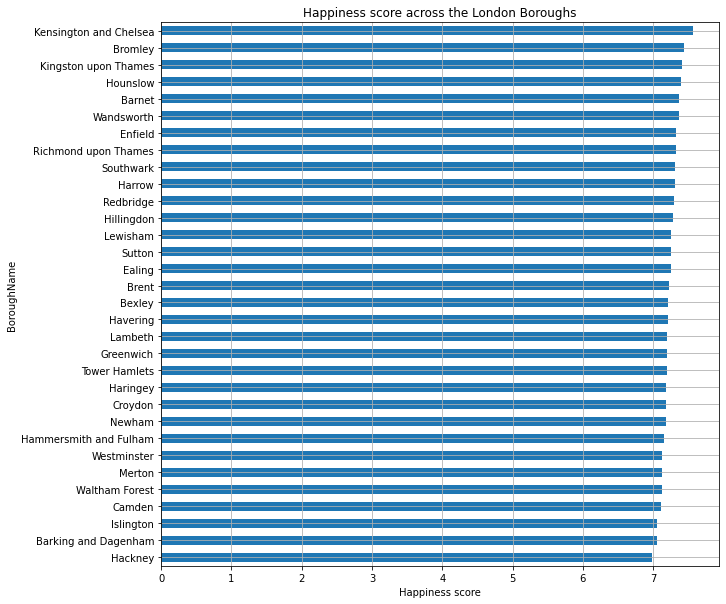

In [17]:
#Visualize Happiness data
data_combined.set_index('BoroughName')['Happiness score'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Happiness score')
plt.title('Happiness score across the London Boroughs')
plt.show()

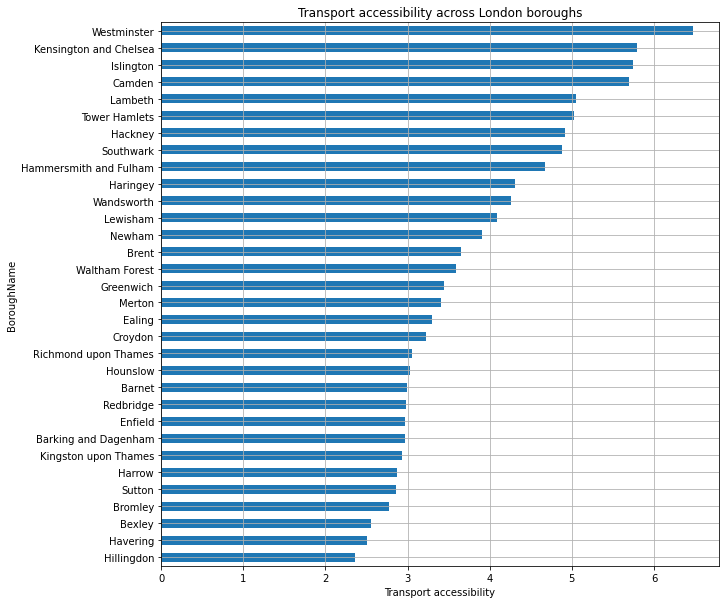

In [18]:
#Visualize transport accessibility data
data_combined.set_index('BoroughName')['Transport accessibility'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Transport accessibility')
plt.title('Transport accessibility across London boroughs')
plt.show()

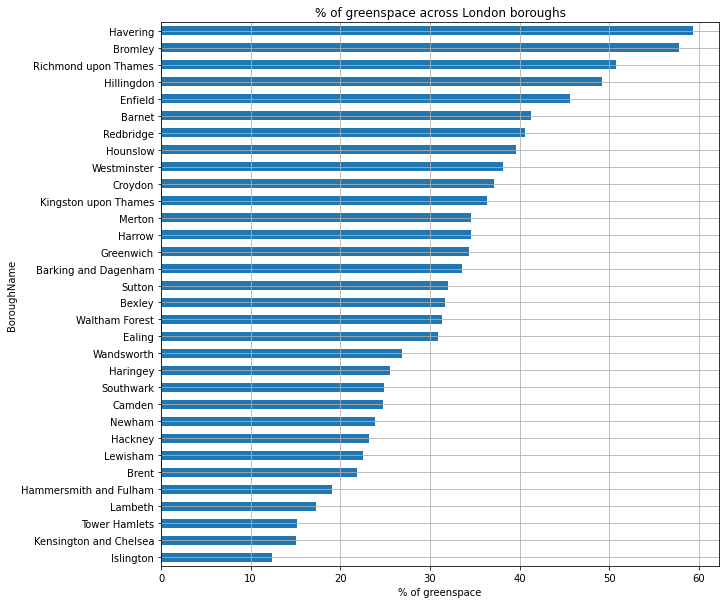

In [19]:
#Visualize % greenspace data
data_combined.set_index('BoroughName')['% of greenspace'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('% of greenspace')
plt.title('% of greenspace across London boroughs')
plt.show()

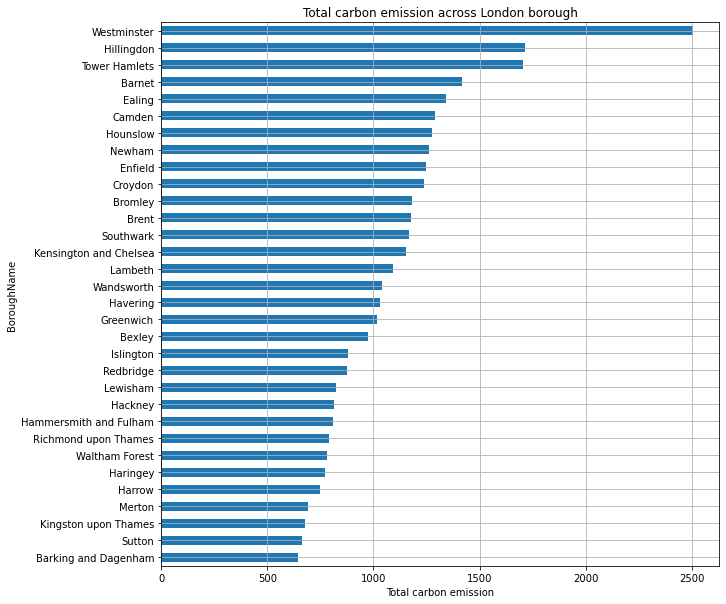

In [20]:
#Visualize carbon emission data
data_combined.set_index('BoroughName')['Total carbon emission'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Total carbon emission')
plt.title('Total carbon emission across London borough')
plt.show()

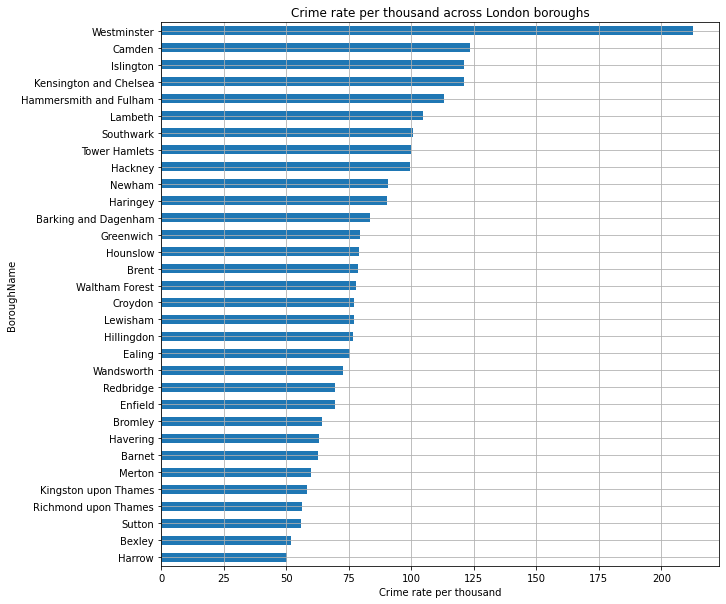

In [21]:
#Visualize crime data
data_combined.set_index('BoroughName')['Crime rate per thousand'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Crime rate per thousand')
plt.title('Crime rate per thousand across London boroughs')
plt.show()

Venues using Foursquare 

In [22]:
CLIENT_ID = 'NQXDDM2NXTTJF14ISWPH4THXICY5IUSGH01GOVYTGPCBNJR2' # your Foursquare ID
CLIENT_SECRET = 'D3VK34JEPFU4UKJB5K3HWFEDC3SD1MW4YTN1U3FWUJJ2V3XH' # your Foursquare Secret
VERSION = '20201224' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NQXDDM2NXTTJF14ISWPH4THXICY5IUSGH01GOVYTGPCBNJR2
CLIENT_SECRET:D3VK34JEPFU4UKJB5K3HWFEDC3SD1MW4YTN1U3FWUJJ2V3XH


In [23]:
#Create a function to explore all borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BoroughName', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
#Get top 50 venues in 500m radius of the center of each Borough
LIMIT = 50
venues = getNearbyVenues(names=info['BoroughName'],
                                   latitudes=info['Latitude'],
                                   longitudes=info['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [25]:
print(venues.shape)
venues.head()

(1139, 7)


,BoroughName,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
2,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts School
3,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket
4,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center


In [26]:
info.head()


,BoroughName,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.5607,0.1557
1,Barnet,369088,51.6252,-0.1517
2,Bexley,236687,51.4549,0.1505
3,Brent,317264,51.5588,-0.2817
4,Bromley,317899,51.4039,0.0198


In [27]:
venues.head()

,BoroughName,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
2,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts School
3,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket
4,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center


In [28]:
address = 'London, UK'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 51.5073219, -0.1276474.


In [29]:
# make a map of London using folium
map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough in zip(data_combined['Latitude'], data_combined['Longitude'], data_combined['BoroughName']):
    label = '{}'.format(borough)
    label2 = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

In [30]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))


There are 194 uniques categories.


In [31]:
# One hot encoding before clustering
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

In [32]:
# Add borough name back to dataframe
borough = venues['BoroughName']
onehot.insert(0, 'BoroughName', borough)
onehot.head()

,BoroughName,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
onehot.shape


(1139, 195)

In [34]:
# Group rows by borough and take the mean of frequency of each venue category
grouped = onehot.groupby('BoroughName').mean().reset_index()
grouped

,BoroughName,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000
1,Barnet,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000
2,Bexley,0.000,0.000000,0.000000,0.000000,0.035714,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.035714,0.000000,0.035714,0.00,0.00,0.00,0.00,0.000000
3,Brent,0.000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000
4,Bromley,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000
5,Camden,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.00,...,0.02,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000
6,Croydon,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000
7,Ealing,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.00,...,0.00,0.000000,0.000000,0.040000,0.000000,0.02,0.00,0.00,0.00,0.000000
8,Enfield,0.000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.020000,0.000000,0.000000,0.00,0.00,0.00,0.02,0.000000
9,Greenwich,0.025,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,...,0.00,0.000000,0.000000,0.025000,0.025000,0.00,0.00,0.00,0.00,0.000000


In [35]:
# top 5 venues for each neighborhood
num_top_venues = 5

for hood in grouped['BoroughName']:
    print("----"+hood+"----")
    temp = grouped[grouped['BoroughName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                  venue  freq
0   Martial Arts School  0.14
1                  Pool  0.14
2           Bus Station  0.14
3           Supermarket  0.14
4  Gym / Fitness Center  0.14


----Barnet----
                        venue  freq
0  Construction & Landscaping  0.25
1                    Bus Stop  0.25
2                        Café  0.25
3          Athletics & Sports  0.25
4          African Restaurant  0.00


----Bexley----
                  venue  freq
0        Clothing Store  0.11
1                   Pub  0.11
2  Fast Food Restaurant  0.07
3              Pharmacy  0.07
4           Coffee Shop  0.07


----Brent----
                 venue  freq
0          Coffee Shop  0.12
1                Hotel  0.10
2  Sporting Goods Shop  0.06
3       Clothing Store  0.06
4        Grocery Store  0.06


----Bromley----
            venue  freq
0  Clothing Store  0.15
1     Coffee Shop  0.12
2    Burger Joint  0.05
3     Pizza Place  0.05
4             Bar  0.05


----Cam

In [36]:
# Put into pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['BoroughName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['BoroughName'] = grouped['BoroughName']

for ind in np.arange(grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Bus Station,Gym / Fitness Center,Supermarket,Martial Arts School,Golf Course,Park,Dive Bar,Falafel Restaurant,Event Space
1,Barnet,Athletics & Sports,Construction & Landscaping,Bus Stop,Café,Dumpling Restaurant,Film Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
2,Bexley,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Coffee Shop,Portuguese Restaurant,Men's Store,Sandwich Place,Restaurant
3,Brent,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Grocery Store,Sandwich Place,Bar,Restaurant,Stadium,Sports Bar
4,Bromley,Clothing Store,Coffee Shop,Burger Joint,Pizza Place,Bar,Gym / Fitness Center,Fast Food Restaurant,English Restaurant,Sushi Restaurant,Sandwich Place


In [37]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [38]:
kclusters = 5
london_cluster = grouped.drop('BoroughName', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_cluster)

kmeans.labels_[0:10]

array([4, 2, 3, 0, 3, 0, 3, 3, 3, 3], dtype=int32)

In [39]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto coords to add latitude/longitude for each neighborhood
london_merged = data_combined
london_merged = london_merged.join(venues_sorted.set_index('BoroughName'), on='BoroughName')

london_merged.head()

,BoroughName,Crime rate per thousand,% of greenspace,Total carbon emission,Transport accessibility,Happiness score,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,83.359060,33.6,643.788244,2.970626,7.05,194352.0,51.560699,0.1557,4,Pool,Bus Station,Gym / Fitness Center,Supermarket,Martial Arts School,Golf Course,Park,Dive Bar,Falafel Restaurant,Event Space
1,Barnet,62.738426,41.3,1415.107370,2.996701,7.37,369088.0,51.625198,-0.1517,2,Athletics & Sports,Construction & Landscaping,Bus Stop,Café,Dumpling Restaurant,Film Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
2,Bexley,51.827942,31.7,974.621259,2.552134,7.21,236687.0,51.454899,0.1505,3,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Coffee Shop,Portuguese Restaurant,Men's Store,Sandwich Place,Restaurant
3,Brent,78.801881,21.9,1175.073235,3.653713,7.22,317264.0,51.558800,-0.2817,0,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Grocery Store,Sandwich Place,Bar,Restaurant,Stadium,Sports Bar
4,Bromley,64.133577,57.8,1179.800587,2.779859,7.44,317899.0,51.403900,0.0198,3,Clothing Store,Coffee Shop,Burger Joint,Pizza Place,Bar,Gym / Fitness Center,Fast Food Restaurant,English Restaurant,Sushi Restaurant,Sandwich Place


In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1- Most balanced borough

In [41]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,BoroughName,Happiness score,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Brent,7.22,317264.0,51.558800,-0.2817,0,Coffee Shop,Hotel,Clothing Store,Sporting Goods Shop,Grocery Store,Sandwich Place,Bar,Restaurant,Stadium,Sports Bar
5,Camden,7.11,229719.0,51.528999,-0.1255,0,Coffee Shop,Café,Burger Joint,Hotel,Train Station,Sandwich Place,Pizza Place,Deli / Bodega,Breakfast Spot,Used Bookstore
20,Lambeth,7.20,314242.0,51.460701,-0.1163,0,Caribbean Restaurant,Market,Indian Restaurant,BBQ Joint,Beer Bar,Pub,Pizza Place,Restaurant,Nightclub,Tapas Restaurant
23,Newham,7.18,318227.0,51.507702,0.0469,0,Hotel,Airport Service,Sandwich Place,Airport Lounge,Airport,Currency Exchange,Pharmacy,Chinese Restaurant,Rafting,Farmers Market
26,Southwark,7.31,298464.0,51.503502,-0.0804,0,Coffee Shop,Hotel,Theater,Hotel Bar,Pub,Art Gallery,English Restaurant,Pizza Place,Yoga Studio,Road
28,Tower Hamlets,7.20,272890.0,51.509899,-0.0059,0,Hotel,Sandwich Place,Italian Restaurant,Coffee Shop,Convenience Store,Light Rail Station,Pizza Place,Café,Steakhouse,Outdoor Sculpture
29,Waltham Forest,7.12,265797.0,51.590801,-0.0134,0,Pub,Art Gallery,Beer Store,Social Club,Tea Room,Vegetarian / Vegan Restaurant,Pool,Coffee Shop,Gym / Fitness Center,Pizza Place
31,Westminster,7.13,226841.0,51.497299,-0.1372,0,Hotel,Coffee Shop,Theater,Hotel Bar,Italian Restaurant,Juice Bar,Sushi Restaurant,Sporting Goods Shop,Clothing Store,Pedestrian Plaza


Cluster 2- Top dining area

In [42]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]


,BoroughName,Happiness score,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Hounslow,7.4,262407.0,51.474602,-0.368,1,Bed & Breakfast,Pizza Place,Park,Café,Yoga Studio,Dumpling Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


CLuster 3- Most diverse entertainment zone

In [43]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]


,BoroughName,Happiness score,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Barnet,7.37,369088.0,51.625198,-0.1517,2,Athletics & Sports,Construction & Landscaping,Bus Stop,Café,Dumpling Restaurant,Film Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


Cluster 4-Boroughs with popular for shopping

In [44]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]


,BoroughName,Happiness score,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bexley,7.21,236687.0,51.454899,0.1505,3,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Coffee Shop,Portuguese Restaurant,Men's Store,Sandwich Place,Restaurant
4,Bromley,7.44,317899.0,51.403900,0.0198,3,Clothing Store,Coffee Shop,Burger Joint,Pizza Place,Bar,Gym / Fitness Center,Fast Food Restaurant,English Restaurant,Sushi Restaurant,Sandwich Place
6,Croydon,7.18,372752.0,51.371399,-0.0977,3,Pub,Coffee Shop,Portuguese Restaurant,Supermarket,Strip Club,Korean Restaurant,Donut Shop,Food Court,Bookstore,Spanish Restaurant
7,Ealing,7.26,342494.0,51.513000,-0.3089,3,Coffee Shop,Italian Restaurant,Pizza Place,Hotel,Burger Joint,Vietnamese Restaurant,Clothing Store,Park,Pub,Portuguese Restaurant
8,Enfield,7.33,320524.0,51.653801,-0.0799,3,Clothing Store,Coffee Shop,Optical Shop,Pub,Supermarket,Shopping Mall,Café,Mobile Phone Shop,Bookstore,Pharmacy
9,Greenwich,7.20,264008.0,51.489201,0.0648,3,Clothing Store,Pub,Coffee Shop,Supermarket,Hotel,Grocery Store,Fast Food Restaurant,Pharmacy,Plaza,Bookstore
10,Hackney,6.99,257379.0,51.544998,-0.0553,3,Pub,Cocktail Bar,Brewery,Bakery,Coffee Shop,Grocery Store,Modern European Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Organic Grocery
11,Hammersmith and Fulham,7.16,178685.0,51.492699,-0.2339,3,Pub,Italian Restaurant,Indian Restaurant,Café,Vietnamese Restaurant,Japanese Restaurant,Clothing Store,Garden Center,Pharmacy,Chinese Restaurant
12,Haringey,7.19,263386.0,51.599998,-0.1119,3,Café,Park,Mediterranean Restaurant,Portuguese Restaurant,Fast Food Restaurant,Supermarket,Light Rail Station,Bus Stop,Bakery,Pub
13,Harrow,7.31,243372.0,51.589802,-0.3346,3,Thai Restaurant,Indian Restaurant,Indie Movie Theater,Coffee Shop,Grocery Store,Supermarket,Yoga Studio,Fast Food Restaurant,Farmers Market,Falafel Restaurant


Cluster 5- The best borough for physical activities

In [45]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(5, london_merged.shape[1]))]]

,BoroughName,Happiness score,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,7.05,194352.0,51.560699,0.1557,4,Pool,Bus Station,Gym / Fitness Center,Supermarket,Martial Arts School,Golf Course,Park,Dive Bar,Falafel Restaurant,Event Space


Results and analysis

In [46]:
total_score = pd.read_excel('Total_score.xlsx')

In [47]:
total_score.head()

,BoroughName,Transport Accessibility Score,Happiness Score,Greenspace Score,Crime Rate Score,Carbon Emission Score,Total Score
0,Barking and Dagenham,3.0,7.1,6.64,5.830,7.853333,30.423333
1,Barnet,3.0,7.4,5.87,6.865,5.283333,28.418333
2,Bexley,2.6,7.2,6.83,7.410,6.750000,30.790000
3,Brent,3.7,7.2,7.81,6.060,6.083333,30.853333
4,Bromley,2.8,7.4,4.22,6.795,6.066667,27.281667


In [48]:
score= pd.merge(total_score, info)

In [49]:
total_score.round(1)

,BoroughName,Transport Accessibility Score,Happiness Score,Greenspace Score,Crime Rate Score,Carbon Emission Score,Total Score
0,Barking and Dagenham,3.0,7.1,6.6,5.8,7.9,30.4
1,Barnet,3.0,7.4,5.9,6.9,5.3,28.4
2,Bexley,2.6,7.2,6.8,7.4,6.8,30.8
3,Brent,3.7,7.2,7.8,6.1,6.1,30.9
4,Bromley,2.8,7.4,4.2,6.8,6.1,27.3
5,Camden,5.7,7.1,7.5,3.8,5.7,29.9
6,Croydon,3.2,7.2,6.3,6.2,5.9,28.7
7,Ealing,3.3,7.3,6.9,6.2,5.5,29.3
8,Enfield,3.0,7.3,5.4,6.5,5.8,28.1
9,Greenwich,3.4,7.2,6.6,6.0,6.6,29.8


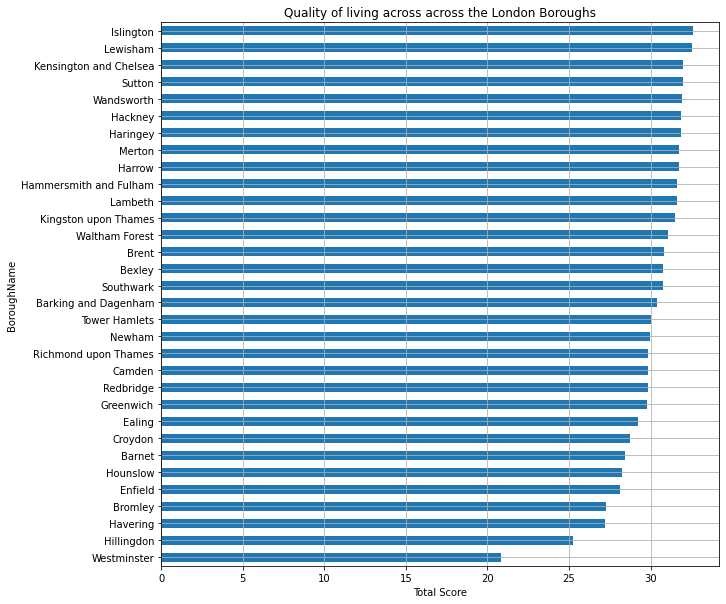

In [50]:
#Visualize total score data
total_score.set_index('BoroughName')['Total Score'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Total Score')
plt.title('Quality of living across across the London Boroughs')
plt.show()